In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, ndimage
import pandas as pd

from astropy import table
from astropy import wcs
from astropy import units as u
from astropy.io import fits
from astropy import cosmology,coordinates
from astropy.visualization import make_lupton_rgb

import sep

from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfstats import sampling, fit, functions
from ekfparse import query

from carpenter import pixels
from agrias import photometry, utils

import sys
sys.path.append('../scripts')
import reader


cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [4]:
gefn = reader.mk_geav()

In [5]:
ms = reader.merianselect(maglim=24., pmin=0.3)

[merianselect] Only choosing sources with m_i < 24.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3
[merianselect] only choosing sources with griz photometry


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
galname = 'J115348.67+012654.60'
dirname = '../local_data/cutouts/manual/savedir_keynote/'

In [7]:
band = 'N708'
def load_image (galname, band, dirname, return_full=False):
    if band in ['N708','N540']:
        survey='merian'
        suffix = {'psf':'_merpsf','im':'_merim'}
    else:
        survey='hsc'
        suffix = {'psf':'_psf','im':''}
        band = f'HSC-{band}'

    src = fits.open(f'{dirname}/{survey}/{galname}_{band}{suffix["im"]}.fits')
    psf = fits.getdata(f'{dirname}/{survey}/{galname}_{band}{suffix["psf"]}.fits', 0)
    
    img = src[1]
    var = src[3]
    #hdr = src[1].header
    if return_full:
        return src, psf
    return img, var, psf

In [8]:
bbmb_d = {'N540':pixels.BBMBImage ( ),'N708':pixels.BBMBImage()}
center_wcs = coordinates.SkyCoord(178.45, 1.445, unit=('deg','deg'))
for band in ['g','N540','r','N708','i']:
    img, var, psf = load_image(galname, band, dirname)
    if center_wcs is None:
        center = np.array(img.data.shape)/2.
        center_wcs = wcs.WCS(img).pixel_to_world(*center)
        #size = img.data.shape[0]  
    size = 1400

    if band in ['g','r','i']:
        bbmb_l = [bbmb_d['N540'],bbmb_d['N708']]
    elif band in ['N540']:
        bbmb_l = [bbmb_d['N540']]
    elif band in ['N708']:
        bbmb_l = [bbmb_d['N708']]
    for bbmb in bbmb_l:
        bbmb.add_band ( band, center_wcs, size, img, var, psf )

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_99800/1837541496.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='../local_data/cutouts/manual/savedir_keynote//hsc/J115348.67+012654.60_HSC-g.fits'>
  img, var, psf = load_image(galname, band, dirname)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_99800/1837541496.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='../local_data/cutouts/manual/savedir_keynote//merian/J115348.67+012654.60_N540_merim.fits'>
  img, var, psf = load_image(galname, band, dirname)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_99800/1837541496.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='../local_data/cutouts/manual/savedir_keynote//hsc/J115348.67+012654.60_HSC-r.fits'>
  img, var, psf = load_image(galname, band, dirname)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_99800/1837541496.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='../local_data/cutouts/man

In [9]:
for bbmb in bbmb_d.values():
    fwhm_a, _ = bbmb.measure_psfsizes()
    psf_match = True
    if psf_match:
        mim, mpsf = bbmb.match_psfs ( np.argmax(fwhm_a) )

[SEDMap] Matching PSFs
    Copying to matched arrays ... 
        ... Done.
    Convolving matching kernel for g ...
         ... Done.
    Convolving matching kernel for r ...
         ... Done.
    Convolving matching kernel for i ...
         ... Done.
[SEDMap] Matching PSFs
    Copying to matched arrays ... 
        ... Done.
    Convolving matching kernel for g ...
         ... Done.
    Convolving matching kernel for r ...
         ... Done.
    Convolving matching kernel for i ...
         ... Done.


In [10]:
src,_ = load_image(galname, 'N708', dirname, return_full=True)

In [11]:
zp = 27. # 2.5*np.log10(63095734448.01944)

In [12]:
mbexcess_d = {}

bbmb = bbmb_d['N708']
mbexcess_d['N708'] = photometry.mbestimate_halpha(
    bbmb.matched_image['N708'].flatten(), #possibly_has_spectrum[utils.photcols['N708']].values,
    bbmb.matched_image['g'].flatten(), #possibly_has_spectrum[utils.photcols['g']].values,
    bbmb.matched_image['r'].flatten(), #possibly_has_spectrum[utils.photcols['r']].values,
    bbmb.matched_image['i'].flatten(), #possibly_has_spectrum[utils.photcols['i']].values,
    None,#bbmb.matched_image['z'].flatten(), #possibly_has_spectrum[utils.photcols['z']].values,
    0.08,
    bbmb.matched_var['N708'].flatten()**.5,
    bbmb.matched_var['r'].flatten()**.5,
    bbmb.matched_var['i'].flatten()**.5,
    apercorr=None,
    ge_correction=gefn([178.4528, 1.4485]),
    ex_correction=None,
    ns_correction=None,
    do_aperturecorrection=False,
    do_gecorrection=True,
    do_extinctioncorrection=False,
    do_linecorrection=False,
    specflux_unit=10.**(27./-2.5) * 3631. * u.Jy,
    ctype='linear',
    plawbands='ri'
)


bbmb = bbmb_d['N540']
mbexcess_d['N540'] = photometry.mbestimate_halpha(
    bbmb.matched_image['N540'].flatten(), #possibly_has_spectrum[utils.photcols['N708']].values,
    bbmb.matched_image['g'].flatten(), #possibly_has_spectrum[utils.photcols['g']].values,
    bbmb.matched_image['r'].flatten(), #possibly_has_spectrum[utils.photcols['r']].values,
    bbmb.matched_image['i'].flatten(), #possibly_has_spectrum[utils.photcols['i']].values,
    None,#bbmb.matched_image['z'].flatten(), #possibly_has_spectrum[utils.photcols['z']].values,
    0.08,
    bbmb.matched_var['N540'].flatten()**.5,
    bbmb.matched_var['g'].flatten()**.5,
    bbmb.matched_var['r'].flatten()**.5,
    wv_eff_mb=5400.,
    apercorr=None,
    ge_correction=gefn([178.4528, 1.4485]),
    ex_correction=None,
    ns_correction=None,
    do_aperturecorrection=False,
    do_gecorrection=False,
    do_extinctioncorrection=False,
    do_linecorrection=False,
    specflux_unit=10.**(27./-2.5) * 3631. * u.Jy,
    ctype='linear',
    plawbands='gr'
)


In [13]:
band = 'N540'
def build_excessmap ( band ):
    bbmb = bbmb_d[band]
    excessmap = mbexcess_d[band][0][0].value.reshape(bbmb.image['r'].shape)
    u_excessmap = mbexcess_d[band][0][1].value.reshape(bbmb.image['r'].shape)
    
    cat, segmap = sep.extract(bbmb.matched_image['r'], 10, var=bbmb.matched_var['r'], segmentation_map=True, minarea=100)
    cat = table.Table(cat)
    cat['r_mag'] = -2.5*np.log10(cat['flux']) + zp
    gm = []
    im = []
    for lbl in np.arange(1, len(cat)+1):
        gm.append( -2.5*np.log10(bbmb.matched_image['g'][segmap==lbl].sum()) + zp)
        im.append( -2.5*np.log10(bbmb.matched_image['i'][segmap==lbl].sum()) + zp)
    cat['g_mag'] = gm
    cat['i_mag'] = im
    cat['gi'] = cat['g_mag'] - cat['i_mag']
    
    brightobj_mask = np.in1d(segmap, np.arange(1,len(cat)+1)[cat['g_mag'] < 18.]).reshape(segmap.shape).astype(int)
    red_mask = np.in1d(segmap, np.arange(1,len(cat)+1)[cat['gi'] > 1.]).reshape(segmap.shape).astype(int)
    highvar_mask = (bbmb.matched_var[band] > 0.1).astype(int)

    objmask = brightobj_mask|red_mask|highvar_mask
    return excessmap,u_excessmap, objmask, segmap

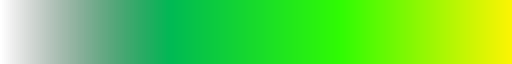

In [14]:
cmap_d = {}
cmap_d['N708'] = ec.colormap_from_list(
    [
        ec.ColorBase('k').translucify(0.),
        ec.ColorBase('#034efc'),
        ec.ColorBase('#03befc'),
        ec.ColorBase('#03fcb1'),
        ec.ColorBase('#03fc41')
    ]
)
cmap_d['N540'] = ec.colormap_from_list(
    [
        ec.ColorBase('k').translucify(0.),
        ec.ColorBase('#00ba54'),
        ec.ColorBase('#30fc03'),
        ec.ColorBase('#fcf403'),        
        
    ]
)
cmap_d['N540']

In [ ]:
cat

In [16]:
bbmb = bbmb_d['N708']
cutout_wcs = wcs.WCS(bbmb.hdu['N708'])
cutout_shape = bbmb.matched_image['g'].shape
center = cutout_wcs.pixel_to_world ( *np.array(cutout_shape)/2.)
mcoords = coordinates.SkyCoord(ms['RA'], ms['DEC'], unit=('deg','deg'))
in_cutout = center.separation(mcoords) < (3*u.arcmin)

pix_cat = cutout_wcs.world_to_pixel(mcoords[in_cutout])
pixscale = cutout_wcs.pixel_scale_matrix[1,1]*3600. # arcsec

Y,X = np.mgrid[:cutout_shape[0],:cutout_shape[1]]
radius = 5. # arcsec
catalog_mask = np.zeros(cutout_shape,dtype=bool)
for idx in range(pix_cat[0].size):
    Rpix = np.sqrt((Y-pix_cat[1][idx])**2 + (X-pix_cat[0][idx])**2)
    Rsky = Rpix * pixscale
    catalog_mask[Rsky<=radius] = True

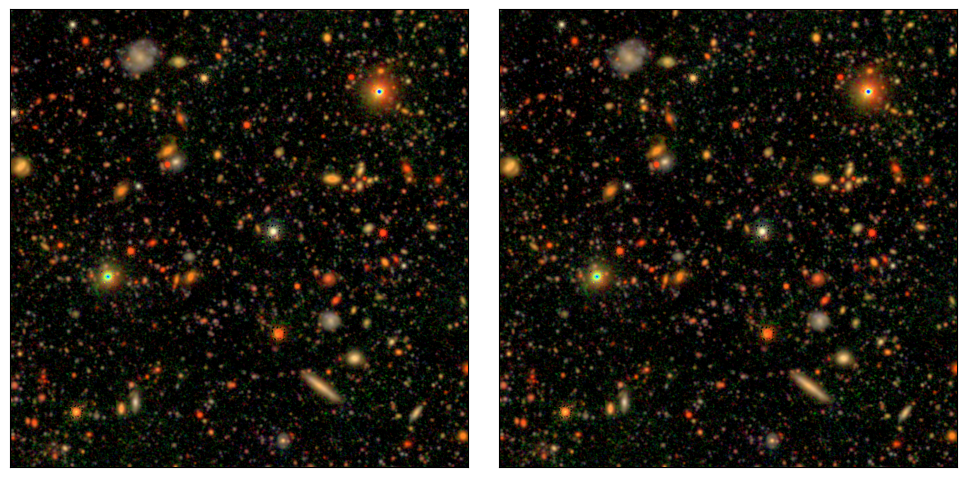

In [31]:
fig, axarr = plt.subplots(1,2,figsize=(10,5))

broadband_rgb = make_lupton_rgb(bbmb.matched_image['i'],bbmb.matched_image['r'],bbmb.matched_image['g'], stretch=0.1, Q=10)
for ax in axarr:
    ax.imshow(broadband_rgb, origin='lower')
                   
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout ()
plt.savefig('/Users/kadofong/Desktop/bb_demo.pdf')


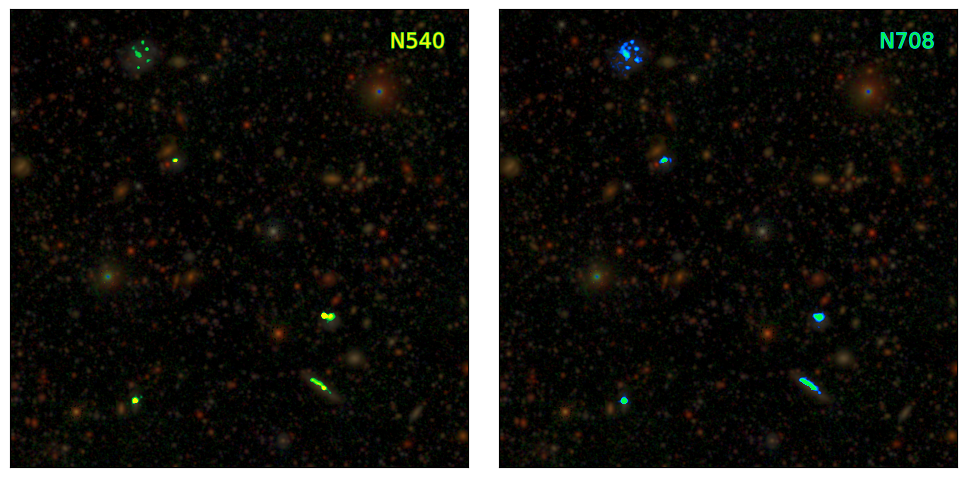

In [28]:
fig, axarr = plt.subplots(1,2,figsize=(10,5))

broadband_rgb = make_lupton_rgb(bbmb.matched_image['i'],bbmb.matched_image['r'],bbmb.matched_image['g'], stretch=0.5, Q=100)
for ax in axarr:
    ax.imshow(broadband_rgb)


for idx,band in enumerate(['N540','N708']):
    ax = axarr[idx]
    excessmap, u_excessmap,objmask, segmap = build_excessmap(band)
    masked_flux = np.where(objmask, 0., excessmap*1e19)
    vmin = 0.
    vmax = np.nanquantile(masked_flux[masked_flux>0.],.95)
    masked_flux = np.where(catalog_mask, masked_flux, 0.)
    

    im = ax.imshow(ndimage.gaussian_filter(masked_flux,3), cmap=cmap_d[band], vmin=vmin,vmax=vmax, origin='lower')

    ek.text(
        0.95, 
        0.95,
        band,
        color=cmap_d[band](1.),
        ax=ax,
        bordercolor=cmap_d[band](0.5),
        fontsize=15
    )
                   
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout ()
plt.savefig('../figures/emission_demo.pdf', dpi=300)
plt.savefig('/Users/kadofong/Downloads/emission_demo.png')